## Demo 1: Run a DNN on an accelerator, get energy and latency breakdown

In this demo, we show how to use ZigZag API function to obtain the energy/latency/EDP of running a DNN on an accelerator (with the best mapping found by ZigZag).

### 1) Explain the API function

```
energy, latency, cmes = get_hardware_performance_zigzag(workload,
                                                        accelerator,
                                                        mapping=None,
                                                        opt='latency',
                                                        dump_filename_pattern",
                                                        pickle_filename")
```
##### Inputs to the function
- **workload**: A neural network model defined in ONNX format or ZigZag's own format.
- **accelerator**: A high-level HW architecture description.
- **mapping**: A file that specifies core allocation, spatial mapping, and memory operand link.
(Note: mapping is needed if the workload is defined in onnx format, else is embedded in the workload.)
- **opt**: Optimization target. It can be 'energy', 'latency', or 'EDP'.
- **dump_filename_pattern**: The name of the result file.
- **pickle_filename**: The name of the file which includes all the detailed metadata for analysing and debugging.

##### Output of the function
- **energy**: A number that indicates the overall consumed energy for running the workload on the accelerator in the user-defined optimized way.
- **latency**: A number that indicates the overall latency (cycle count) for running the workload on the accelerator in the user-defined optimized way.
- **cmes**: A collection of all the detailed cost model evaluation results. "cme" stands for "cost model evaluation".



### 2) Prepare the inputs

In [1]:
# Get the workload
onnx_model_path = "alexnet.onnx"
workload = onnx_model_path

# Get the accelerator and mapping
from zigzag.inputs.examples.mapping.alexnet_on_edge_tpu_like import mapping as mapping
from zigzag.inputs.examples.hardware.Edge_TPU_like import accelerator as accelerator

# Set the filenames
dump_filename_pattern=f"outputs/Edge_TPU-AlexNet-layer_?.json"
pickle_filename = "outputs/Edge_TPU-AlexNet-saved_list_of_cmes.pickle"

### 3) Run ZigZag API

In [2]:
from zigzag.api import get_hardware_performance_zigzag

energy, latency, cmes = get_hardware_performance_zigzag(workload=workload,
                                                        accelerator=accelerator,
                                                        mapping=mapping,
                                                        opt='energy',
                                                        dump_filename_pattern=dump_filename_pattern,
                                                        pickle_filename=pickle_filename)

2023-02-07 20:47:42,203 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-07 20:47:42,208 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-07 20:47:42,209 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-07 20:47:42,210 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-07 20:47:42,211 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-07 20:47:42,212 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-07 20:47:42,212 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-07 20:47:42,213 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-07 20:47:42,213 - parse_workload_from_onnx_model_and_mapping +101 - INFO - Created ONNXWorkload graph with 24 nodes and 23 edges.
2023-02-07 20:47:42,214 - run +33 - INFO - Processing layer 0...
2023-02-07 20:47:42,215 - run +81 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 8), 'D2': ('C'

### 4) View the outputs

In [3]:
print(f"Total network energy = {energy:.2e} pJ")
print(f"Total network latency = {latency:.2e} cycles")

Total network energy = 5.66e+09 pJ
Total network latency = 8.35e+06 cycles


As logged during our ZigZag run, a list of 8 CMEs is saved to 'pickle_filename'. We load in this list and use the built-in visualization script to show an energy and latency breakdown for each of the layers. As the last fully connected layers are a clear bottleneck (you can verify this yourself by plotting all the CMEs instead of only the first 5), they are not plotted in this example.

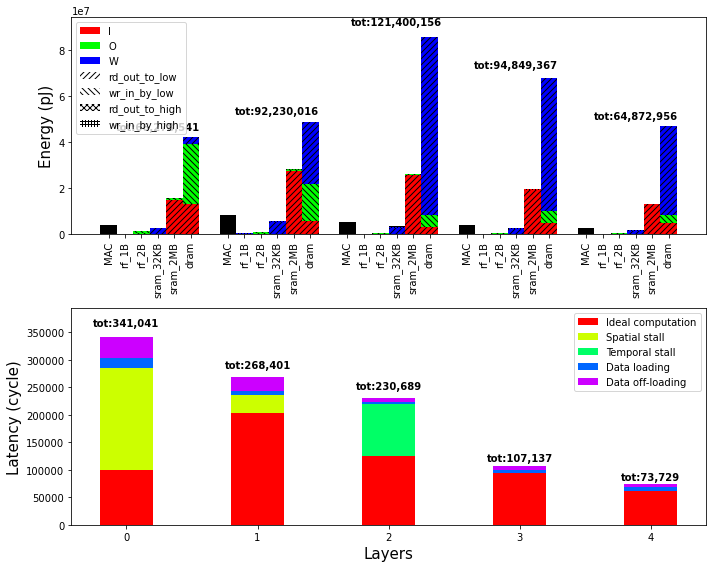

In [4]:
import pickle
from zigzag.visualization.results.plot_cme import bar_plot_cost_model_evaluations_breakdown

# Load in the pickled list of CMEs
with open(pickle_filename, 'rb') as fp:
    breakdown_cmes = pickle.load(fp)

# Plot all the layers and save to 'plot_all.png'
bar_plot_cost_model_evaluations_breakdown(breakdown_cmes[:5], save_path="plot_breakdown.png")


As mentioned, this plot shows the different layers of AlexNet. It has two core components: the top one showing the energy breakdown, and the bottom one latency breakdown. 

#### Energy breakdown

Different layer shapes have different activation sizes (I/O) and parameter sizes (W), which cause a varying number of memory accesses, depending on the layout of the memory hierarchy for each of these operands and the achievable reuse for each operand within each memory.

#### Latency breakdown

Different aspects impact the latency. The spatial under-utilization of the array leads to "spatial stalls", where as insufficient memory bandwidth can lead to "temporal stalls".